In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# set global display format
pd.set_option('display.float_format', '{:,.2f}'.format)

# set global plotting style
plt.style.use('seaborn-darkgrid')
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 15

In [3]:
# define helper functions
def find_top(df, index=None, top_n=10, all=False, sort_by='TotalHours'):
    result = (pd.pivot_table(df, values=['MeetingID', 'DurationHours'],
                             index=index,
                             aggfunc={'MeetingID': 'count',
                                      'DurationHours': 'sum'},
                             fill_value=0,
                             margins=True,
                             margins_name='Total')
              .rename(columns={'MeetingID': 'TotalCalls',
                               'DurationHours': 'TotalHours'})
              .sort_values(sort_by, ascending=False)
              .eval('MinPerCall = TotalHours/TotalCalls * 60'))
    if all:
        return result.reset_index(level=1).iloc[1:, :]
    else:
        return result.iloc[:top_n+1, :]


def find_customer_objective(df, customer_no, customer_name, thresh=85):
    objectives = (df.query('CustomerNo == @customer_no & CustomerName == @customer_name')
                  .groupby(['CustomerName', 'Objective'])
                  .agg({'DurationHours': 'sum'})
                  .rename(columns={'DurationHours': 'TotalHours'})
                  .sort_values('TotalHours', ascending=False))
    objectives['PctTotal'] = objectives*100 / objectives.sum()
    objectives['PctTotalCumSum'] = objectives.groupby(level='CustomerName')['PctTotal'].cumsum() 
    
    return objectives.query('PctTotalCumSum <= @thresh')

## Load Dataset

In [5]:
calls = pd.read_csv('..\\data\\raw\\call_history_ai_2019.csv',
                    dtype={'Caller ID': 'str',
                           'Customer No': 'str',
                           'Notes': 'str',
                           'Dialed Number': 'str',
                           'Dialed Branch No': 'str'},
                    parse_dates=['Call Start', 'Call Saved'])
calls.columns = calls.columns.str.replace('\W', '')

# create call duration by hour
# calls['DurationHours'] = (calls['CallSaved'] - calls['CallStart']).dt.total_seconds() / 60 / 60

# export interim dataset for other notebooks
calls.set_index('MeetingID').to_pickle('..\\data\\interim\\call_history_ai_2019.pkl')

In [13]:
spend = pd.read_csv('..\\data\\raw\\spend_w_clusters.csv',
                    index_col='CustomerNo',
                    dtype={'CustomerNo': 'str',
                           'Size_ClusterDesc': 'str',
                           'SupportReliance_ClusterDesc': 'str',
                           'Loyalty_ClusterDesc': 'str',
                           'Profitability_ClusterDesc': 'str'})
spend.columns = spend.columns.str.replace('_ClusterDesc', '')
spend.drop_duplicates(inplace=True)
spend = spend.query('Expenditure_5YAVG_PartsNServices >= 0')

# create customer ranking by expenditure
spend['ExpPNSRank'] = spend['Expenditure_5YAVG_PartsNServices'].rank(ascending=False).astype('int')
spend['ExpTotalRank'] = spend['Expenditure_5YAVG_Total'].rank(ascending=False).astype('int')

spend.to_pickle('..\\data\\interim\\spend_w_clusters.pkl')

In [6]:
afterhours = calls.query('CallType == "Afterhours"')
queues = calls.query('CallType == "Queue Call"')

## Top Customers
### All Call Types

In [7]:
# top customers by total number of calls
top_n = 10
column_order = ['Total', 'Queue Call', 'Afterhours', 'Direct Call', 'Walk In']
customers_calls_all = (pd.pivot_table(calls, values='MeetingID',
                                      index=['CustomerNo', 'CustomerName'],
                                      columns=['CallType'],
                                      aggfunc='count', fill_value=0,
                                      margins=True, margins_name='Total')
                       .sort_values('Total', ascending=False)[column_order])

customers_calls_all.iloc[:top_n+1, :]

,CallType,Total,Queue Call,Afterhours,Direct Call,Walk In
CustomerNo,CustomerName,,,,,
Total,,143815,142257,1286,159,113
N000800,VISA /MASTERCARD ACCOUNT NL,1437,1437,0,0,0
1615545,BATTLEFIELD EQUIPMENT RENTAL S,1127,1124,3,0,0
4361445,BERNT GILBERTSON ENTERPRISES LIMITED,700,690,10,0,0
8607870,TACC CONSTRUCTION LTD.,695,694,1,0,0
3446650,894882 ONTARIO INC. O/A G. GORDON ENTERPRISES,646,643,3,0,0
241902,INLAND KENWORTH,629,628,1,0,0
4478085,GRAHAM BROS CONSTRUCTION LIMITED,579,577,2,0,0
7328475,PILEN CONSTR OF CANADA LTD,549,548,1,0,0


In [8]:
# top customers by total number of hours
find_top(calls, index=['CustomerNo', 'CustomerName']).iloc[1:, :].sum()

TotalHours   5,277.93
TotalCalls   6,198.00
MinPerCall     719.12
dtype: float64

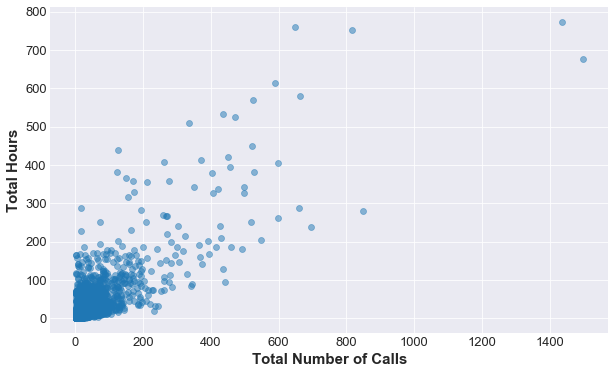

In [9]:
# correlation between total number of calls and total hours
customers_calls = calls.groupby('CustomerNo').agg({'MeetingID': 'count', 'DurationHours': 'sum'})

fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
sns.scatterplot(x='MeetingID', y='DurationHours',
                alpha=0.5, edgecolor=None,
                data=customers_calls, ax=ax)
plt.xlabel('Total Number of Calls')
plt.ylabel('Total Hours')
plt.show()

### Queue Calls

In [10]:
# top Queue Calls customers by total hours
top_customers_queues = find_top(queues, index=['CustomerNo', 'CustomerName'])
top_customers_queues

,,TotalHours,TotalCalls,MinPerCall
CustomerNo,CustomerName,,,
Total,,"96,453.68",142257,40.68
N000800,VISA /MASTERCARD ACCOUNT NL,773.17,1437,32.28
4361445,BERNT GILBERTSON ENTERPRISES LIMITED,655.69,690,57.02
241902,INLAND KENWORTH,573.46,628,54.79
195048,L. CHABOT ENTERPRISES LTD.,525.91,469,67.28
1615545,BATTLEFIELD EQUIPMENT RENTAL S,491.56,1124,26.24
5560245,WILLIAMS OPERATING CORPORATION,468.87,311,90.46
1165996,ALGOMA STEEL INC.,462.98,450,61.73
259259,FAST BROTHERS (1978) LTD.,450.74,520,52.01


In [11]:
# top objectives for Queue Calls
find_top(queues, index=['Objective'])

,TotalHours,TotalCalls,MinPerCall
Objective,,,
Total,"119,695.29",165239,43.46
Not parts call,"39,078.01",29045,80.73
Availability of parts,"23,775.60",26471,53.89
General info/other,"18,093.62",25377,42.78
Sale without part number,"8,928.01",20149,26.59
Sale with a part number,"7,634.83",25890,17.69
Transfer - parts,"6,445.43",11701,33.05
Tracking an order,"4,576.95",9656,28.44
Quote/request for price without part number(s),"4,519.11",6065,44.71


In [12]:
# top Queue Calls customers with their 5 year parts & service spend
spend_columns = ['Expenditure_5YAVG_PartsNServices', 'ExpPNSRank', 'ExpTotalRank']
(top_customers_queues.reset_index(level=1).iloc[1:, :2]
 .join(spend.loc[:, spend_columns], how='inner')
 .sort_values('TotalHours', ascending=False)
 .eval('ExpPerHour = Expenditure_5YAVG_PartsNServices / TotalHours'))

# **Exp Per Hour functions as a proxy to evaluate overall priority,
# not a reflection of revenue generated by calls

,CustomerName,TotalHours,Expenditure_5YAVG_PartsNServices,ExpPNSRank,ExpTotalRank,ExpPerHour
CustomerNo,,,,,,
N000800,VISA /MASTERCARD ACCOUNT NL,773.17,"559,585.86",155,718,723.75
4361445,BERNT GILBERTSON ENTERPRISES LIMITED,655.69,"1,439,507.32",63,72,"2,195.42"
241902,INLAND KENWORTH,573.46,"1,715,307.40",53,181,"2,991.15"
195048,L. CHABOT ENTERPRISES LTD.,525.91,"353,552.88",250,401,672.26
1615545,BATTLEFIELD EQUIPMENT RENTAL S,491.56,"15,229,389.07",4,6,"30,981.77"
5560245,WILLIAMS OPERATING CORPORATION,468.87,"7,169,450.15",9,17,"15,290.79"
1165996,ALGOMA STEEL INC.,462.98,"2,182,747.82",36,66,"4,714.54"
259259,FAST BROTHERS (1978) LTD.,450.74,"149,225.08",498,645,331.07
005551,CASTLE OILFIELD CONSTRUCTION LIMITED,436.78,"74,148.88",829,1916,169.76


In [13]:
# find top ~80% objectives by customer
results = pd.DataFrame()
customers_list = top_customers_queues.iloc[1:, :].reset_index()
for no, name in zip(customers_list.CustomerNo, customers_list.CustomerName):
    results = pd.concat([results,
                         find_customer_objective(queues, thresh=90,
                                                 customer_no=no, customer_name=name)])
results

TotalHours  \
CustomerName                          Objective                                                 
VISA /MASTERCARD ACCOUNT NL           Availability of parts                            516.25   
                                      Transfer - parts                                 153.37   
BERNT GILBERTSON ENTERPRISES LIMITED  General info/other                               241.35   
                                      Availability of parts                            173.64   
                                      Not parts call                                   118.40   
                                      Transfer - parts                                  54.82   
INLAND KENWORTH                       Not parts call                                   181.18   
                                      Availability of parts                            177.81   
                                      General info/other                               107.26   
L. CHABOT ENTERPRISES LTD.            Not parts call                                   257.10   
                                      Availability of parts                            128.83   
                                      General info/other                                68.01   
BATTLEFIELD EQUIPMENT RENTAL S        General info/other                               132.68   
                                      Availability of parts                            106.24   
                                      Not parts call                                    81.82   
                                      Tracking an order                                 71.21   
                                      Sale with a part number                           37.90   
WILLIAMS OPERATING CORPORATION        General info/other                               161.06   
                                      Availability of parts                            154.67   
                                      Quote/request for price with part number(s)       69.80   
ALGOMA STEEL INC.                     Availability of parts                            183.36   
                                      General info/other                               120.57   
                                      Not parts call                                    82.08   
                                      Transfer - parts                                  20.78   
FAST BROTHERS (1978) LTD.             Not parts call                                   144.81   
                                      Availability of parts                            124.30   
                                      General info/other                                94.87   
                                      Tracking an order                                 24.32   
CASTLE OILFIELD CONSTRUCTION  LIMITED Not parts call                                   366.02   
BATTLEFIELD EQUIPMENT RENTAL S        Not parts call                                   161.79   
                                      General info/other                               140.89   
                                      Tracking an order                                 51.34   

                                                                                   PctTotal  \
CustomerName                          Objective                                               
VISA /MASTERCARD ACCOUNT NL           Availability of parts                           66.77   
                                      Transfer - parts                                19.84   
BERNT GILBERTSON ENTERPRISES LIMITED  General info/other                              36.81   
                                      Availability of parts                           26.48   
                                      Not parts call                                  18.06   
                                      Transfer - parts                                 8.36   
INLAND KENWORTH         

### Afterhours

In [14]:
find_top(afterhours, index=['CustomerNo', 'CustomerName'])

,,TotalHours,TotalCalls,MinPerCall
CustomerNo,CustomerName,,,
Total,,"2,010.45",1286,93.80
0001012,LAFARGE CANADA INC. (BROOKFIELD),166.36,1,"9,981.85"
6928000,NORTH YORK GENERAL HOSPITAL,165.13,1,"9,908.05"
1351080,TOR CASH SALES,152.32,12,761.61
N059680,CAPITAL READY MIX,138.18,1,"8,290.90"
139504,THUNDER BAY REGIONAL HEALTH SCIENCE CENTRE,116.57,7,999.21
6447500,MIDOME CONSTRUCTION SERVICES,115.10,1,"6,905.78"
3502845,GOLDCORP DOME O/A GOLDCORP,95.43,27,212.06
250669,THUNDERPINE LEASING INC.,94.91,1,"5,694.45"


In [15]:
find_top(afterhours, index=['CustomerNo', 'CustomerName'], sort_by='TotalCalls')

,,TotalHours,TotalCalls,MinPerCall
CustomerNo,CustomerName,,,
Total,,"2,010.45",1286,93.80
3495150,ARCELORMITTAL DOFASCO G.P.,1.78,29,3.68
3502845,GOLDCORP DOME O/A GOLDCORP,95.43,27,212.06
5016100,THE HOME DEPOT INC,1.15,21,3.27
3367175,DETOUR GOLD CORPORATION,0.71,20,2.13
4766900,HARSCO METALS CANADA,9.43,20,28.28
5607050,LAKESHORE GOLD CORP,4.26,15,17.04
1351080,TOR CASH SALES,152.32,12,761.61
8441010,STELCO INC.,1.59,12,7.95


In [16]:
find_top(afterhours, index=['Objective'])

,TotalHours,TotalCalls,MinPerCall
Objective,,,
Total,"2,010.51",1287,93.73
Service query- forwarded to oncall service contact,889.90,636,83.95
Parts Sale,679.63,266,153.30
Afterhours Hosebuild,296.41,95,187.21
Parts Query-forwarded to oncall parts contact,129.50,112,69.38
Tracking an order,4.14,54,4.60
Afterhours Parts Pickup,3.91,23,10.19
Sales Call,3.58,14,15.35
TC query,1.88,38,2.96


## Top Queue Call Customers by Segmentation

In [19]:
customers_segmentation = find_top(queues, index=['CustomerNo', 'CustomerName'], all=True).join(spend)
c = (customers_segmentation.groupby(['Loyalty', 'Size', 'SupportReliance', 'Profitability'])
      .agg({'TotalHours': 'sum'})
      .rename(columns={'TotalHours': '% of Total Hours'})
      .sort_values('% of Total Hours', ascending=False))
(c*100 / c.sum()).iloc[:top_n+1, :]

% of Total Hours
Loyalty                 Size               SupportReliance     Profitability                                    
CAT Owner, high freq    giants             Regular Maintenance Hi Profitability, ave payspeed              10.99
                                           Needs Basis         Hi Profitability, ave payspeed               9.45
                                                               Ave Profitability, Ave Payspeed              8.54
                                           Regular Maintenance Ave Profitability, Ave Payspeed              4.80
                        small independents Needs Basis         Ave Profitability, Ave Payspeed              4.75
                                           Regular Maintenance Hi Profitability, ave payspeed               4.72
                                                               Ave Profitability, Ave Payspeed              3.68
                                           Needs Basis         Hi Profitability, ave payspeed               3.19
                        giants             Needs Basis         Ave Profitability, Lo Payspeed               2.97
CAT Owner, low freq     small independents Needs Basis         Ave Profitability, Ave Payspeed              2.85
CAT Owner, focused Comp small independents Needs Basis         Ave Profitability, Ave Payspeed              2.14

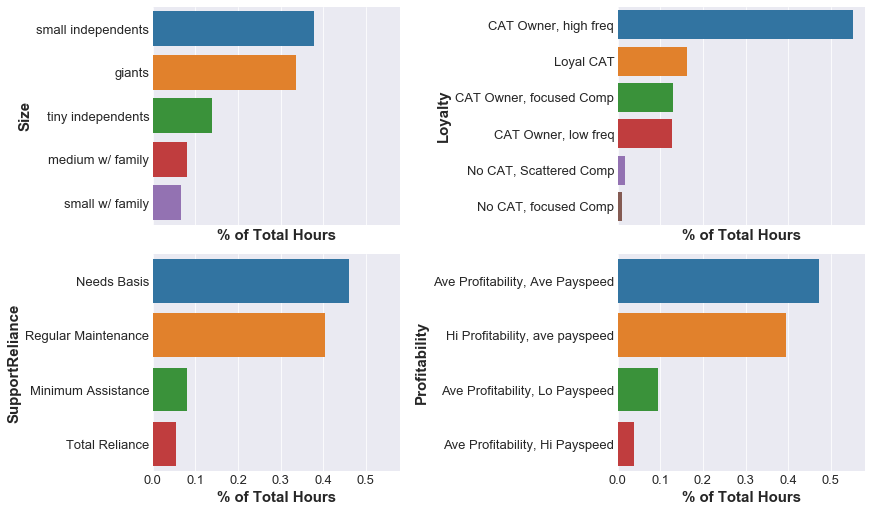

In [20]:
# call hours distribution by segments
segments = ['Size', 'Loyalty', 'SupportReliance', 'Profitability']

fig, axes = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True, sharex=True)
axes = axes.ravel()

for i, s in enumerate(segments):
    df = (customers_segmentation.groupby(s)
          .agg({'TotalHours': 'sum'})
          .rename(columns={'TotalHours': 'Hours'})
          .sort_values('Hours', ascending=False))
    ax = sns.barplot(x='Hours', y=s, ax=axes[i],
                     data=(df / df.sum()).reset_index())
    ax.set(xlabel='% of Total Hours')

plt.show()

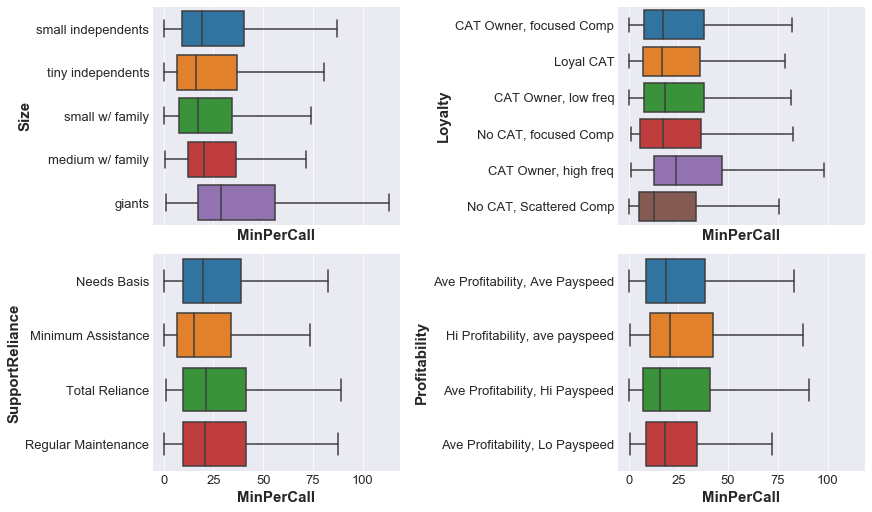

In [21]:
# Min per call distribution by segments
fig, axes = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True, sharex=True)
axes = axes.ravel()

for i, s in enumerate(segments):
    sns.boxplot(x='MinPerCall', y=s, ax=axes[i],
                data=customers_segmentation,
                showfliers=False)

plt.show()

## Top Branches

In [22]:
# top branches for queue calls
find_top(queues, index=['Branch'])

,TotalHours,TotalCalls,MinPerCall
Branch,,,
Total,"119,695.29",165239,43.46
Winnipeg,"17,319.78",18843,55.15
Sault Ste Marie,"13,528.53",9614,84.43
Brandon,"12,011.01",5953,121.06
Ottawa,"11,613.38",11378,61.24
London,"11,348.72",11360,59.94
Toronto Branch,"10,648.12",25392,25.16
Thunder Bay,"10,100.56",11997,50.52
Timmins,"5,702.77",6150,55.64


In [71]:
(queues.query('Branch == "Brandon        "')
 .groupby(['Branch', 'Contact', 'Objective'])
 .agg({'DurationHours': 'sum', 'MeetingID':'count'})
 .rename(columns={'DurationHours': 'TotalHours', 'MeetingID': 'TotalCalls'})
 .eval('MinPerCall = TotalHours/TotalCalls * 60')
 .groupby(level=1, group_keys=False)
 .apply(lambda x: x.sort_values(('TotalHours'), ascending=False)))

TotalHours  \
Branch          Contact          Objective                                                    
Brandon         Andrew Griffith  Not parts call                                    6,727.91   
                                 General info/other                                2,812.07   
                                 Transfer - parts                                    540.16   
                                 Availability of parts                               148.13   
                                 Quote/request for price without part number(s)      116.81   
                                 Tracking an order                                    69.00   
                                 Transfer - service                                   65.21   
                                 Sale with a part number                              48.95   
                                 Sale without part number                             23.46   
                                 Quote/request for price with part number(s)          19.46   
                                 Transfer - specialty call                             0.46   
                Jonathan Katcsma Not parts call                                      850.19   
                                 General info/other                                  224.01   
                                 Tracking an order                                   128.27   
                                 Sale without part number                             92.60   
                                 Sale with a part number                              86.78   
                                 Transfer - parts                                     48.87   
                                 Quote/request for price without part number(s)        3.46   
                                 Quote/request for price with part number(s)           2.51   
                                 Transfer - service                                    1.58   
                                 Availability of parts                                 1.13   

                                                                                 TotalCalls  \
Branch          Contact          Objective                                                    
Brandon         Andrew Griffith  Not parts call                                        1330   
                                 General info/other                                    1133   
                                 Transfer - parts                                       160   
                                 Availability of parts                                  114   
                                 Quote/request for price without part number(s)          38   
                                 Tracking an order                                       81   
                                 Transfer - service                                       9   
                                 Sale with a part number                                141   
                                 Sale without part number                                69   
                                 Quote/request for price with part number(s)             23   
                                 Transfer - specialty call                                3   
                Jonathan Katcsma Not parts call                                        1686   
                                 General info/other                                     305   
                                 Tracking an order                                       99   
                                 Sale without part number                               228   
                                 Sale with a part number                                322   
                                 Transfer - parts                                       175   
                                 Quote/request for price without part number(s)          1

In [76]:
(queues.query('Branch == "Brandon        " & Contact == "Andrew Griffith" & DurationHours > 1')
 .sort_values('MeetingID', ascending=False))

,MeetingID,CallerID,Influencer,CustomerNo,CustomerName,CallType,Contact,Branch,Objective,PartsDocumentNumber,Notes,DialedNumber,DialedBranchNo,DialedBranch,Scordcard,Reviewer,Rating,CallStart,CallSaved,DurationHours
124862,1165495,204 747 4159,NaN,NaN,NaN,Queue Call,Andrew Griffith,Brandon,Not parts call,NaN,NaN,1821,63,Brandon,nan,NaN,nan,2019-03-13 16:03:07,2019-03-19 14:24:19,142.35
126103,1163859,204 526 7577,TREVOR ROBINSON,005551,CASTLE OILFIELD CONSTRUCTION LIMITED,Queue Call,Andrew Griffith,Brandon,Not parts call,NaN,NaN,1821,63,Brandon,nan,NaN,nan,2019-03-13 08:55:31,2019-03-18 08:41:15,119.76
126100,1163862,204 734 6097,NaN,NaN,NaN,Queue Call,Andrew Griffith,Brandon,Not parts call,NaN,NaN,1821,63,Brandon,nan,NaN,nan,2019-03-13 11:21:26,2019-03-18 08:41:46,117.34
126098,1163865,204 747 4159,NaN,NaN,NaN,Queue Call,Andrew Griffith,Brandon,Not parts call,NaN,NaN,1821,63,Brandon,nan,NaN,nan,2019-03-13 16:19:44,2019-03-18 08:42:14,112.38
126102,1163860,204 526 7577,TREVOR ROBINSON,005551,CASTLE OILFIELD CONSTRUCTION LIMITED,Queue Call,Andrew Griffith,Brandon,Not parts call,NaN,NaN,1821,63,Brandon,nan,NaN,nan,2019-03-13 16:51:15,2019-03-18 08:41:32,111.84
126104,1163858,204 526 7577,TREVOR ROBINSON,005551,CASTLE OILFIELD CONSTRUCTION LIMITED,Queue Call,Andrew Griffith,Brandon,Not parts call,NaN,NaN,1821,63,Brandon,nan,NaN,nan,2019-03-13 16:51:15,2019-03-18 08:41:04,111.83
126097,1163866,204 851 0140,NaN,NaN,NaN,Queue Call,Andrew Griffith,Brandon,Not parts call,NaN,NaN,1821,63,Brandon,nan,NaN,nan,2019-03-13 17:15:43,2019-03-18 08:42:22,111.44
129374,1159225,204 851 0140,NaN,NaN,NaN,Queue Call,Andrew Griffith,Brandon,Not parts call,NaN,NaN,1821,63,Brandon,nan,NaN,nan,2019-03-08 14:11:08,2019-03-11 14:52:24,72.69
129375,1159224,204 474 2414,ROB ROBINSON,130159,BATTLEFIELD EQUIPMENT RENTAL S,Queue Call,Andrew Griffith,Brandon,General info/other,NaN,NaN,1820,61,Winnipeg,nan,NaN,nan,2019-03-08 16:35:35,2019-03-11 14:52:07,70.28
153413,1125760,204 790 6575,AARON .,220050,MAXIM INTERNATIONAL TRUCKS W,Queue Call,Andrew Griffith,Brandon,Not parts call,NaN,NaN,1820,61,Winnipeg,nan,NaN,nan,2019-01-25 11:54:27,2019-01-28 08:33:37,68.65


In [ ]:
# top branches for afterhour calls
find_top(afterhours, index=['Branch', 'Contact'])

In [ ]:
# parts related columns
['Parts Sale', 'Sale with a part number', 'Availability of parts', 'Sale without part number', 
 'Transfer - parts', 'Quote/request for price with part number(s)', 'Arranging Direct Ship from CAT', 
 'Quote/request for price without part number(s)', 'Lost sale', 'Sales Call', 'Parts pickup']

# afterhour list
['Afterhours Hosebuild', 'Afterhours Parts Pickup', 'Parts Query-forwarded to oncall parts contact']

# service related columns
['Transfer - service', 'Service query- forwarded to oncall service contact', 'TC query']

# non-revenue columns
['Not parts call', 'Transfer - specialty call', 'Tracking an order', 'General info/other']

In [ ]:
## TO-DO
# Correlate PSSR PARs with call time